# DTSA 5510 Final Project
# NCAA Men's Basketball Tournament Seeding 

## Introduction
Every year the NCAA hosts a tournament to crown a champion. The yearly tournament currently invites 68 teams to compete in venues across the country in March and April. Colloquially, this tournament is known as March Madness. Many people follow the tournament and it generates a lot of excitement in the US. So much so that predicting the winners has become a yearly tradition for many people. Kaggle has hosted a March Machine Learning Mania competition yearly with the goal of predicting the winners of each game. I will use the data set provided by that competition but to find different insights.

Teams work all year to get selected to this tournament. Teams will get automatic bids if they win their athletic conference-- otherwise, a team will need to secure an at-large bid. At-large bids get handed out by a group of 'experts' that compare teams and make selections. Every year controversy arises regarding the teams who get left out... this project won't address that.  

Instead, this project will try and project team seeding. All tournament teams are good, but we will vary in how good. After teams get selected for the tournament, the selection committee puts teams in groups ranked from 1 to 16; four teams in each group (two seeds will have 6 teams, these are known as the first four teams, we won't worry about that here). Sports pundits will often argue about appropriate seeding in the tournament. After all, a better seed means that you will play relatively weaker seeds earlier in the tournament, helping your chances to advance. Teams receiving a high seed receive quite an advantage. Therefore, it's crucial to get the seeding as accurate as possible. This project will attempt to develop unsupervised learning models to cluster teams into groups with other like teams based on their stats, and their opponent’s stats-- hopefully taking the subjectivity out of the process.  

This project will consider the last ten years of the men’s tournament.

Our first step will be reading in the data and loading python libraries.

### Github repo for this project
https://github.com/sideyco/DTSA_5510


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
# read in files
MTeams_import = pd.read_csv('/kaggle/input/march-machine-learning-mania-2025/MTeams.csv')
MNCAATourneySeeds_import = pd.read_csv('/kaggle/input/march-machine-learning-mania-2025/MNCAATourneySeeds.csv')
MRegularSeasonDetailedResults_import = pd.read_csv('/kaggle/input/march-machine-learning-mania-2025/MRegularSeasonDetailedResults.csv')
MTeamConferences_import = pd.read_csv('/kaggle/input/march-machine-learning-mania-2025/MTeamConferences.csv')


In [45]:
# make copies to work with
MTeams = MTeams_import.copy()
MNCAATourneySeeds = MNCAATourneySeeds_import.copy()
MRegularSeasonDetailedResults = MRegularSeasonDetailedResults_import.copy()
MTeamConferences = MTeamConferences_import.copy()

## Data
There's a lot of data Kaggle provides for their competition. Each year teams play in thousands of games, and several years’ worth of data were provided. Kaggle acknowledges Kenneth Massey and Jeff Sonas for assembling the data for this competition.  

I need game statistics for the regular season games of all teams making the tournament. I decided not to include conferences that the teams play in, the conference games will account for a majority of their regular season games; I can use this as a proxy for strength of schedule, but in this use case I think the algorithms will want to group teams in the same conference together and I want to see where the teams fall based on their objective stats. These statistics include things like score, shooting percentage, three point shots made, turn overs, rebounds, etc. I will use the statistics for the winning and losing team in each game played by the tournament teams.  

After the cleaning, formatting, and feature engineering, I have a data frame with two columns of integers, and 64 columns of floats.


In [5]:
# data frame info
MTeams.info()
MNCAATourneySeeds.info()
MRegularSeasonDetailedResults.info()
MTeamConferences.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TeamID         380 non-null    int64 
 1   TeamName       380 non-null    object
 2   FirstD1Season  380 non-null    int64 
 3   LastD1Season   380 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 12.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2626 entries, 0 to 2625
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Season  2626 non-null   int64 
 1   Seed    2626 non-null   object
 2   TeamID  2626 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118882 entries, 0 to 118881
Data columns (total 34 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Season   118882 non-null  int64 
 1   DayNum   118882 non-

In [6]:
MTeamConferences

,Season,TeamID,ConfAbbrev
0,1985,1102,wac
1,1985,1103,ovc
2,1985,1104,sec
3,1985,1106,swac
4,1985,1108,swac
...,...,...,...
13383,2025,1476,nec
13384,2025,1477,southland
13385,2025,1478,nec
13386,2025,1479,nec


## Initial Cleaning
### Cleaning Tournament Seeds
I filtered tournament seeds to relevant years. The seeds also included an indicator of their tournament region, and if they were a 'first four' team; I removed those indicators. 

### Winning and Losing Teams
Each row of the `MRegularSeasonDetailedResults` frame contains game data. This includes stats for both the winning and losing team. I decided to keep both teams stats in the data; another way to capture the strength of the opponent being played. To accomplish this, I matched the IDs from the tournament teams to the winning and losing team IDs in the results frame separately. I changed column names to match on 'Team' and 'Opp' instead of 'W' (winning) and 'L' (losing) team stats. I then appended the two frames. Finally, I added a 1 to the win column for the winning team and a 0 for the loser so I could keep track of winning percentage. 

### Home and Away
Basketball games played at a teams' home court provides several advantages and we want to keep that information in the data. Originally the data contains a column for WLoc, meaning the winning teams location, represented as a 'H', 'N', or 'A' (N for neutral site games). I used some logic and the `np.where()` function to assign the appropriate locations the the separated winning and losing frames. After appending, I grouped by season, team, and location, then calculated the mean for all of ther other columns; I grouped home and away separately and considered neutral sites to be away games. Now with these different home and away groupings, I mereged the columns back onto the base frame of tournament teams. The final result shows the season and team IDs, followed by a set of columns for their home game stats, then a set of columns for their away game stats.  

### Final Touches
I included squared team and opponent scores for a little additional feature engineering. This comes from the idea of Pythagorean expectation.
https://en.wikipedia.org/wiki/Pythagorean_expectation

In [7]:
# only want teams that made the tournament from 2015-2025
MNCAATourneySeeds = MNCAATourneySeeds[MNCAATourneySeeds['Season'] >= 2015]

# clean the letter from Seed
# regions start with W, X, Y, Z; first four teams have an a or b on the end
MNCAATourneySeeds['Seed'] = MNCAATourneySeeds['Seed'].str.replace('W|X|Y|Z|a|b', '', regex = True)


MNCAATourneySeeds.groupby('Seed')['TeamID'].count()

Seed
01    40
02    40
03    40
04    40
05    40
06    40
07    40
08    40
09    40
10    42
11    57
12    41
13    40
14    40
15    40
16    60
Name: TeamID, dtype: int64

In [8]:
# now we need to join the game details to the teams
# first we will join the winning teams to the tournament teams in frame df_w
# then we will join the losing teams to the tournament teams in frame df_l
# finally we will join the frames to get all games for all tournament teams

# start with a base table of tournament teams, won't need their seeds here
base = MNCAATourneySeeds[['Season', 'TeamID']]

# frame for all the games tournament teams won
df_w = pd.merge(
    base
    , MRegularSeasonDetailedResults
    , how = 'inner'
    , left_on = ['Season', 'TeamID']
    , right_on = ['Season', 'WTeamID']
    , suffixes = ['', 'team_won']
)

# clean up column names
df_w = df_w.drop(columns = ['DayNum', 'WTeamID', 'LTeamID'])

# add a column for win or loss
df_w['win'] = 1

# frame for all the games tournament teams lost
df_l = pd.merge(
    base
    , MRegularSeasonDetailedResults
    , how = 'inner'
    , left_on = ['Season', 'TeamID']
    , right_on = ['Season', 'LTeamID']
    , suffixes = ['', 'team_lost']
)

# clean up column names
df_l = df_l.drop(columns = ['DayNum', 'WTeamID', 'LTeamID'])

# add a column for win or loss
df_l['win'] = 0

In [9]:
# check the size of the frames
print(df_w.shape)
print(df_l.shape)

# that makes sense, we'd expect a lot more winners, I'm actually suprised there are this many loser entries

(15451, 33)
(6011, 33)


In [10]:
# now we need to rename the columns so we can merge the winning and losing frames
# then we will aggregate to get their season statistics

# for Team stats, ex WFGM, change W to Team_
df_w.columns = df_w.columns.str.replace('W', 'Team_')

# for Opp stats, ex LFGM, change L to Opp_
df_w.columns = df_w.columns.str.replace('L', 'Opp_')

# flip it for the df_l frame
df_l.columns = df_l.columns.str.replace('L', 'Team_')
df_l.columns = df_l.columns.str.replace('W', 'Opp_')

In [11]:
# need to handle location, gets renamed strangly to Team_Opp_oc, could fix that
# will split frames into home and away, treating neutral games as away
# then bring them back as column sets

# clean the df_w frame
df_w['Team_Opp_oc'] = np.where(
    df_w['Team_Opp_oc'] == 'H'
    , 'H'
    , 'A'
)
df_w = df_w.rename(columns = {'Team_Opp_oc': 'Loc'})

# clean the df_l frame
df_l['Opp_Team_oc'] = np.where(
    df_l['Opp_Team_oc'] == 'A'
    , 'H'
    , 'A'
)
df_l = df_l.rename(columns = {'Opp_Team_oc': 'Loc'})



In [12]:
# append the win and loss frames
df_all = pd.concat([df_w, df_l])

# add a squared score column
# this comes from the idea of pythagorean expectation
# not sure if it will help or hurt
df_all['Team_Score_Sq'] = df_all['Team_Score']**2
df_all['Opp_Score_Sq'] = df_all['Opp_Score']**2

#df_all.head()

In [13]:
# split the frames into home and away
# will have column sets for both these 
df_home = df_all[df_all['Loc'] == 'H']
df_away = df_all[df_all['Loc'] == 'A']

In [14]:
# group the home games and get the mean statistics
grp_home = df_home.groupby(['Season', 'TeamID', 'Loc']).mean().reset_index()

# add suffix to the column names
grp_home = grp_home.add_suffix('_Home')


# group the away games and get the mean statistics
grp_away = df_away.groupby(['Season', 'TeamID', 'Loc']).mean().reset_index()

# add suffix to the column names
grp_away = grp_away.add_suffix('_Away')

In [15]:
# join the groups back onto base
# join home game columns
df = pd.merge(
    base
    , grp_home
    , how = 'inner'
    , left_on = ['Season', 'TeamID']
    , right_on = ['Season_Home', 'TeamID_Home']
)
# drop duplicate columns
df = df.drop(columns = ['Season_Home', 'TeamID_Home', 'Loc_Home'])

# join away game columns
df = pd.merge(
    df
    , grp_away
    , how = 'inner'
    , left_on = ['Season', 'TeamID']
    , right_on = ['Season_Away', 'TeamID_Away']
)
# drop duplicate columns
df = df.drop(columns = ['Season_Away', 'TeamID_Away', 'Loc_Away'])

In [16]:
df.describe()

,Season,TeamID,Team_Score_Home,Opp_Score_Home,NumOT_Home,Team_FGM_Home,Team_FGA_Home,Team_FGM3_Home,Team_FGA3_Home,Team_FTM_Home,...,Opp_OR_Away,Opp_DR_Away,Opp_Ast_Away,Opp_TO_Away,Opp_Stl_Away,Opp_Blk_Away,Opp_PF_Away,win_Away,Team_Score_Sq_Away,Opp_Score_Sq_Away
count,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,...,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000
mean,2020.000000,1290.367647,78.389316,65.400973,0.046517,27.583337,58.267637,7.933198,21.741810,15.289443,...,9.354125,23.237903,12.648921,11.913650,6.012323,3.550802,17.553613,0.601296,5424.013900,5045.617659
std,3.319066,105.588107,5.672884,5.196618,0.071629,2.232992,3.397901,1.462223,3.307434,2.326274,...,1.650562,1.968960,1.610339,1.799763,0.954187,0.700526,1.780869,0.140915,771.505154,744.817311
min,2015.000000,1101.000000,60.312500,47.562500,0.000000,21.250000,44.823529,4.181818,12.000000,8.312500,...,5.200000,16.235294,7.333333,7.263158,3.562500,1.650000,11.615385,0.250000,3220.533333,3022.562500
25%,2017.000000,1209.000000,74.448052,62.000000,0.000000,26.131250,56.110963,6.916667,19.442708,13.677390,...,8.129412,21.758929,11.666667,10.682292,5.314967,3.061581,16.226648,0.500000,4897.704044,4546.750000
50%,2020.000000,1285.000000,78.322917,65.553977,0.000000,27.541958,58.277778,7.881944,21.571429,15.280392,...,9.250000,23.193750,12.644958,11.806250,5.954451,3.500000,17.513158,0.600000,5385.858456,5032.440503
75%,2023.000000,1388.250000,82.129464,68.898325,0.066667,28.886765,60.540210,8.882353,23.866667,16.918269,...,10.557292,24.688702,13.719048,13.117647,6.625000,4.000000,18.714286,0.700000,5904.736111,5491.700000
max,2025.000000,1471.000000,94.176471,80.642857,0.454545,35.176471,67.923077,12.437500,32.888889,20.900000,...,13.750000,28.823529,19.090909,19.352941,8.894737,6.133333,22.647059,1.000000,8435.714286,8089.000000


## EDA
### Histograms
With a prepared data frame for analysis, let's examine the histograms of all these statistics. I know that these already show the mean statistics over a season, so I expect some relatively smooth histograms. If anything looks out of place, I can investigate and do additional cleaning.

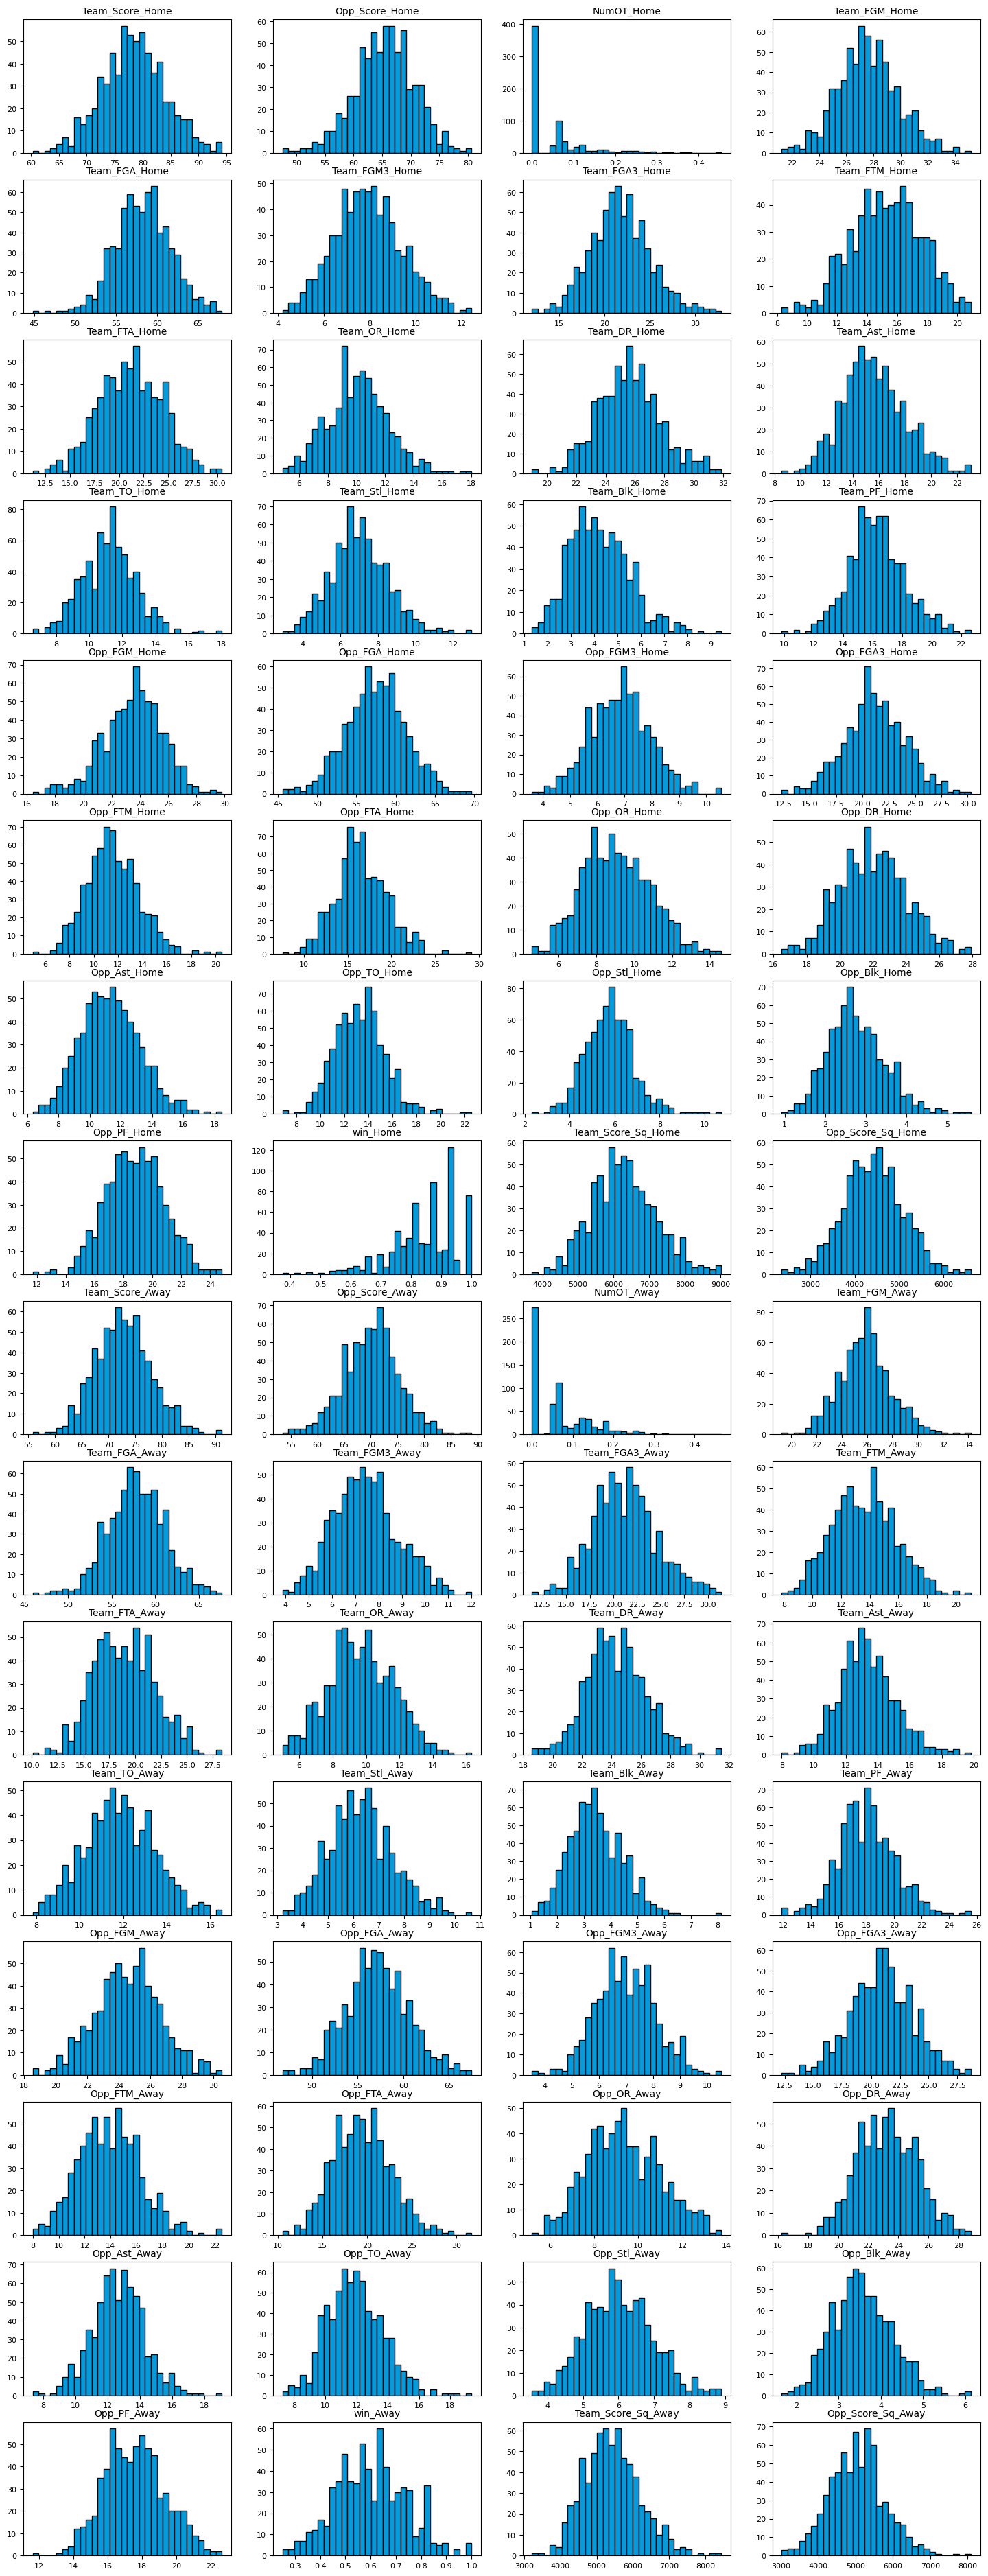

In [17]:
# histograms of the data
# will use a facets to make this more managable

# pick out float columns
f_cols = df.select_dtypes(include = 'float64').columns

# facet dims
n_cols = 4
n_rows = 16

# create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 3))

# Flatten axes array for easy iteration
axes = axes.flatten()

# plot the floats
for i, col in enumerate(f_cols):
    ax = axes[i]
    ax.hist(
        df[col]
        , bins = 32   # 16 * 2 seems reasonble here, we have 16 seeds after all
        , color = '#009CDE'   # NCAA blue
        , edgecolor = 'black'
    )
    ax.set_title(col, fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)


A few observations:
1. The distributions look reasonable, I don't see any major concerns for outliers. I do find it interesting that some tournament teams made it with home winning percentages less than 0.5. I think this information will actually help us.
2. Number of over times played is zero inflated. This is expected as most games won't end with over time periods being played.
3. The scaling shows vastly different values. For example, winning percentage by definition will be between 0 and 1, while a teams' season score total squared will be anywhere between 3000 and 8000. I will use a standard scaler here to make these more relatable.

### Correlation Pair Plots
The data contains too many 

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Text(0.5, 1.0, 'Feature Correlation Heatmap')

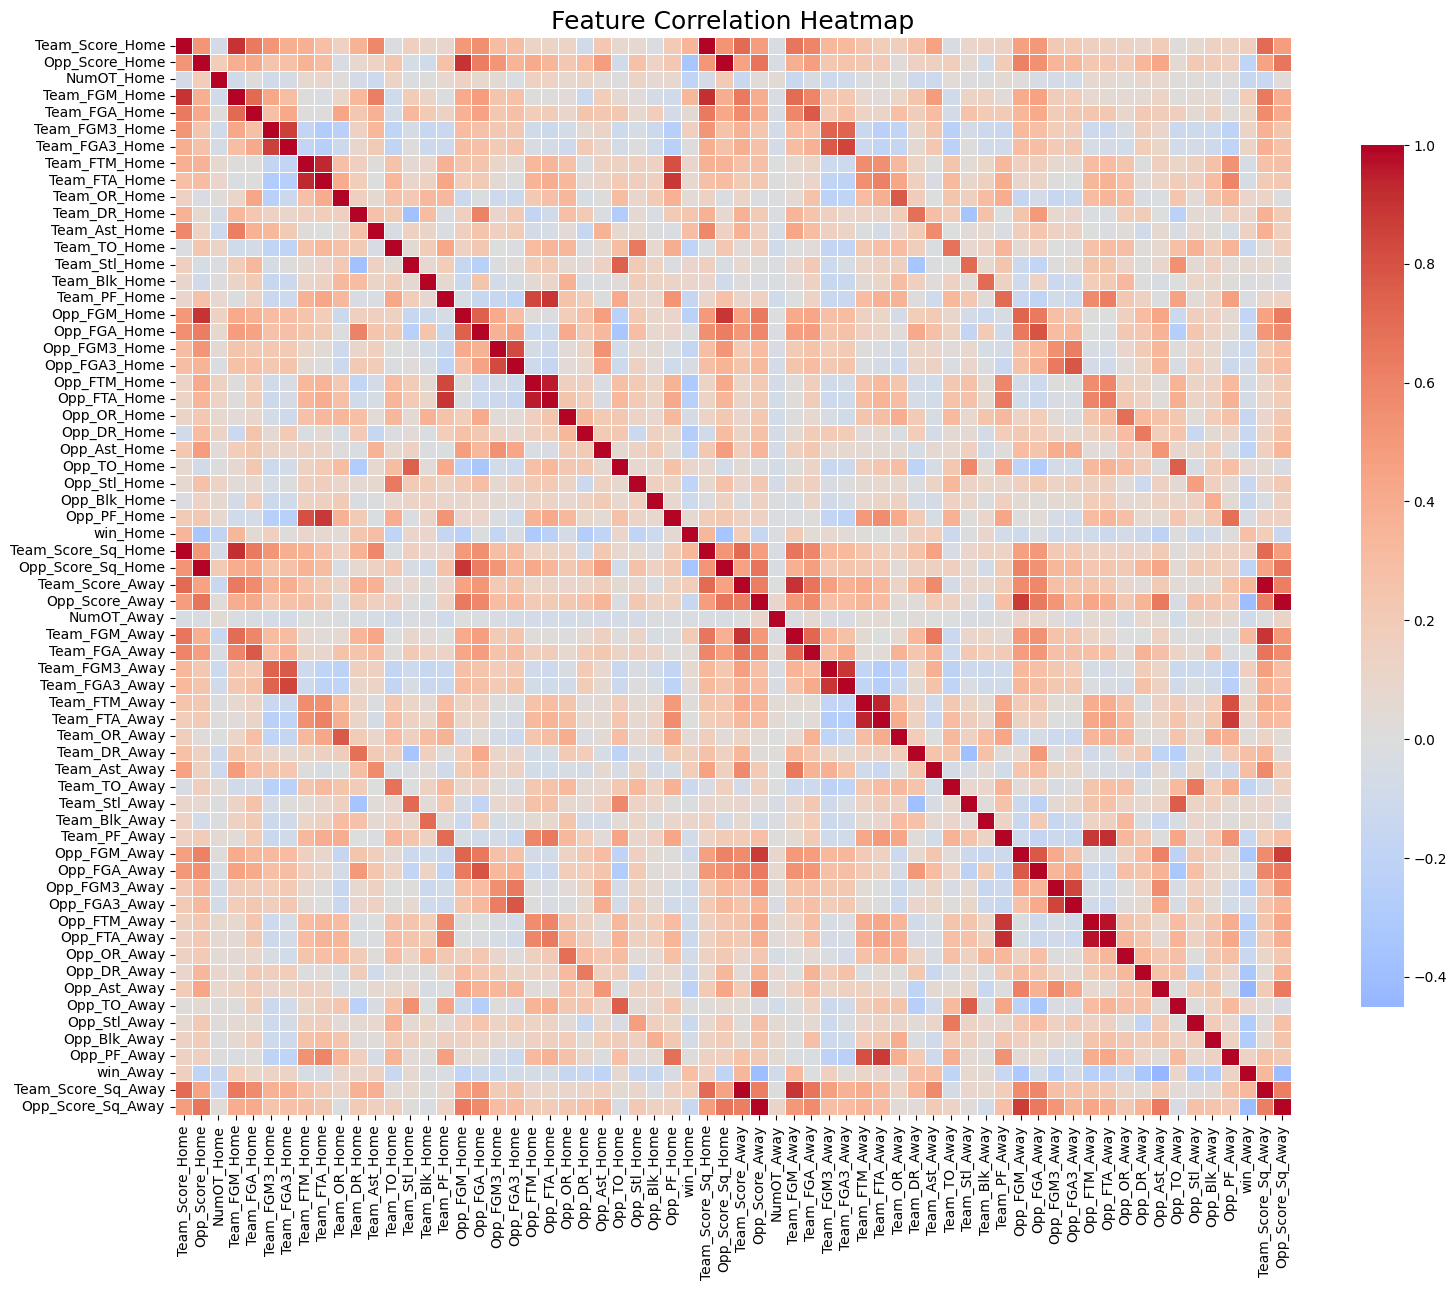

In [18]:
# correlation heat map

# compute the correlation of only the float columns
df_corr = df[f_cols].corr()

# figsize
plt.figure(figsize=(18, 14))

# plot the heatmap
sns.heatmap(
    df_corr
    , cmap='coolwarm'      # blue to red color range
    , center = 0             # center white at 0
    , annot = False          # don't write numbers on cells (too crowded)
    #, fmt = '.2f'            # if annot=True, show 2 decimal places
    , linewidths = 0.5       # small grid lines between cells
    , cbar_kws={"shrink": 0.8}  # shrink the color bar slightly
)


plt.title('Feature Correlation Heatmap', fontsize=18)

### Correlation Table
That's a lot to look at, let's look at the highest correlation intersections in a table.

In [19]:
# chat gpt helped with this code
corr_unstacked = df_corr.unstack()

# remove self-correlations (a variable with itself is always 1.0)
corr_unstacked = corr_unstacked[corr_unstacked < 1.0]

# drop mirrored pairs
corr_unstacked = corr_unstacked.drop_duplicates()

# sort by highest correlation
high_corr_pairs = corr_unstacked.sort_values(ascending=False)

# show top 20
high_corr_pairs.head(30)   # show top 20 most highly correlated feature pairs

Team_Score_Away  Team_Score_Sq_Away    0.997212
Team_Score_Home  Team_Score_Sq_Home    0.997206
Opp_Score_Away   Opp_Score_Sq_Away     0.996635
Opp_Score_Home   Opp_Score_Sq_Home     0.995936
Opp_FTM_Away     Opp_FTA_Away          0.967824
Opp_FTM_Home     Opp_FTA_Home          0.954683
Team_FTM_Away    Team_FTA_Away         0.939064
Team_FTM_Home    Team_FTA_Home         0.927637
Team_PF_Away     Opp_FTA_Away          0.918566
Team_FGM_Home    Team_Score_Sq_Home    0.904024
Team_Score_Home  Team_FGM_Home         0.903417
Opp_Score_Home   Opp_FGM_Home          0.898449
Team_Score_Away  Team_FGM_Away         0.898337
Team_FGM_Away    Team_Score_Sq_Away    0.897639
Team_PF_Home     Opp_FTA_Home          0.893838
Team_FGM3_Away   Team_FGA3_Away        0.892076
Opp_FGM_Home     Opp_Score_Sq_Home     0.890993
Team_PF_Away     Opp_FTM_Away          0.881440
Team_FTA_Home    Opp_PF_Home           0.881120
Team_FTA_Away    Opp_PF_Away           0.879269
Opp_Score_Away   Opp_FGM_Away          0

It seems like adding in the Pythagorean expectation squares was a bad idea here, let's remove them. I will also remove the team home and away scores. Those scores are just linear combinations of field goals made (FGM), 3-pointers made (PGM3), and free throws made (FTM). Personal fouls (PF) also show high correlation with free throw attempts; that also makes total sense so I will remove personal fouls from the data frame too.

Some others that show high correlation like FTM to FTA (made to attempted) I will keep in the data. I think it's an important distinction to know what proportion of shots get made.  

You will also notice a couple additional lines of higher correlation. Those come from the home and away versions of the different statistics. I think keeping these columns will provide meaningful data about the teams that have significant splits in these areas.

In [20]:
# columns to remove
remove_list = [
    'Team_Score_Home'
    , 'Team_Score_Away'
    , 'Opp_Score_Home'
    , 'Opp_Score_Away'
    , 'Team_Score_Sq_Home'
    , 'Team_Score_Sq_Away'
    , 'Opp_Score_Sq_Home'
    , 'Opp_Score_Sq_Away'
    , 'Team_PF_Home'
    , 'Team_PF_Away'
    , 'Opp_PF_Home'
    , 'Opp_PF_Away'
]

df = df.drop(columns = remove_list)

## Additional Preprocessing
As mentioned previously, the statistics I chose for modeling come in very different scales. To handle this, I used Sklearn's StandardScaler(). This allows us to scale the columns to what there values are centered around the mean and divided by their standard deviation:
$$
Transformed Value = \frac{(x - mean)}{std}
$$  

Now all the variables will be on the same scale.

In [21]:
# seperate the features from the ID columns (season, teamID)
X = df.drop(columns = ['Season', 'TeamID']).copy()

# use standard scaler
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)


### Dimensionality Reduction
Even after some feature reduction, our feature space still contains 52 columns! I will use principal component analysis to reduce this space even further. We can use this technique to pull out the strongest eigenvector components that dictate most of the differences between these teams. In doing so, we do lose a bit of interpretability. 

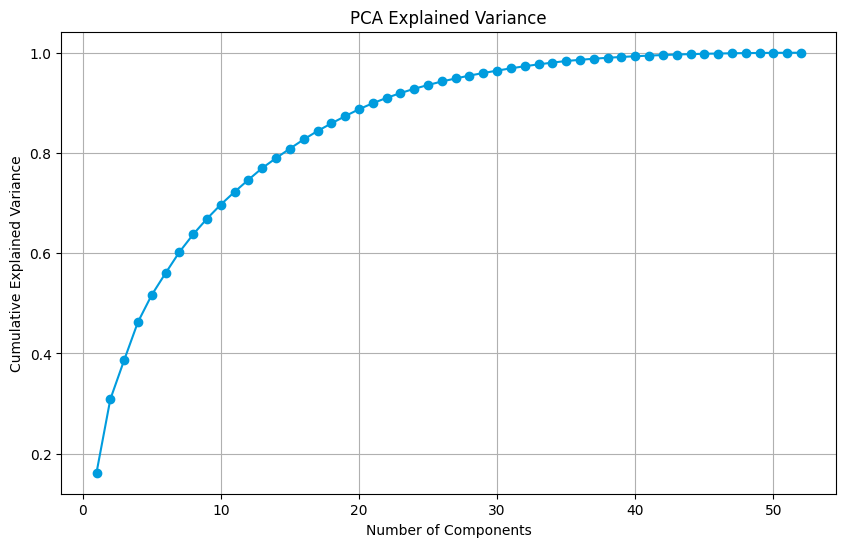

In [22]:
# initialize the pca class
pca = PCA()   # start with all columns

X_pca = pca.fit_transform(X)

# plot the explained variance
plt.figure(figsize=(10,6))
plt.plot(
    range(1, len(pca.explained_variance_ratio_)+1)
    , pca.explained_variance_ratio_.cumsum()
    , marker='o'
    , color = '#009CDE'   # NCAA blue
)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)

When using 10 components, we explain about 70% of the variance in the data. I think that's a good starting point for our clusting algorithms.

In [23]:
# new pca with only the top 10 components
pca_10 = PCA(n_components=10)
X_10 = pca_10.fit_transform(X)



## Modeling 
Let's now model the data. I will use two different clustering algorithms to see what shows more defined clusters. I want to see little distance within clusters and lots of distance between clusters if possible.

### K-Means
I start by using the K-Means clustering class from Sklearn.

In [24]:
# KMeans
kmc = KMeans(
    n_clusters = 16
    , init = 'k-means++'
    , n_init = 'auto'
    , max_iter = 1000
    , verbose = 1
    , random_state = 202504
).fit(X_10)

df['Cluster'] = kmc.labels_

Initialization complete
Iteration 0, inertia 16716.191424768964.
Iteration 1, inertia 13831.813405084918.
Iteration 2, inertia 13262.33329053318.
Iteration 3, inertia 12930.189717285699.
Iteration 4, inertia 12803.644684044608.
Iteration 5, inertia 12736.646515245315.
Iteration 6, inertia 12701.898773417877.
Iteration 7, inertia 12667.139657845139.
Iteration 8, inertia 12633.517569339498.
Iteration 9, inertia 12606.237645633077.
Iteration 10, inertia 12564.963702228939.
Iteration 11, inertia 12542.941970754855.
Iteration 12, inertia 12535.605261656741.
Iteration 13, inertia 12528.181472007625.
Iteration 14, inertia 12520.548159287711.
Iteration 15, inertia 12517.188385137084.
Iteration 16, inertia 12516.445034846616.
Iteration 17, inertia 12515.641575218568.
Converged at iteration 17: strict convergence.


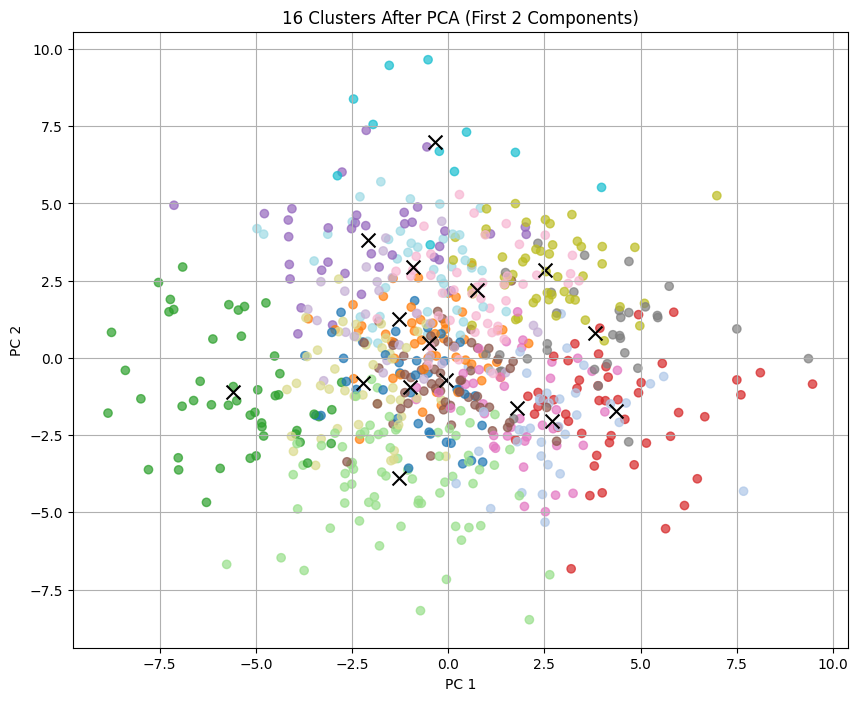

In [25]:
# Quick scatter plot
plt.figure(figsize=(10,8))
plt.scatter(X_10[:,0], X_10[:,1], c=df['Cluster'], cmap='tab20', alpha=0.7)
plt.scatter(kmc.cluster_centers_[:,0], kmc.cluster_centers_[:,1], c='black', marker='x', s=100)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('16 Clusters After PCA (First 2 Components)')
plt.grid(True)
plt.show()

### KMeans Initial Results
Looking at the plot above, some areas have distinct clusters, and others are too noisy to make sense of what's going on. I initially chose clusters = 16, because we're dealing with seeds 1-16. I'm going to experiment with relaxing this constraint. Let's see if we can achieve better cluster inertia (sum of squares within clusters) by using a different number of clusters. We can look at the number of clusters compared to their inertia on a plot to see where we stop seeing good improvement.

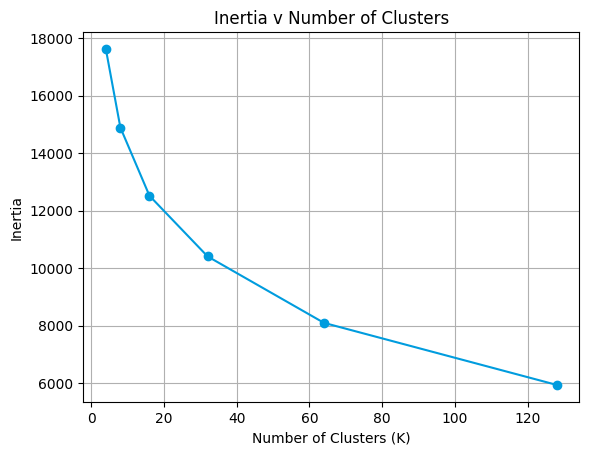

In [26]:
# look at inertia of clusters
inertia = []
ks = [128, 64, 32, 16, 8, 4]
for k in ks:
    kmc = KMeans(
        n_clusters = k
        , init = 'k-means++'
        , n_init = 'auto'
        , max_iter = 1000
        #, verbose = 1
        , random_state = 202504
    ).fit(X_10)
    
    # save the inertia to the list
    inertia.append(kmc.inertia_)

# plot the inertia results
plt.plot(
    ks
    , inertia
    , marker='o'
    , color = '#009CDE'   # NCAA blue
)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Inertia v Number of Clusters')
plt.grid(True)


It still seems like 16 is a good number of clusters. After all, that's the number of seeds we're trying to classify. Using something like 64 clusters only makes sense if we were trying to rank all the teams, and there are better approaches for doing something like that.  

### Tuning `n_init`
Let's try tuning the `n_init` parameter. This will chose the number of different random spots to start the clusters. If we test more starting coordinates, we may end up with more precise results. Our current inertia is measured at 12539.5 for 16 clusters.

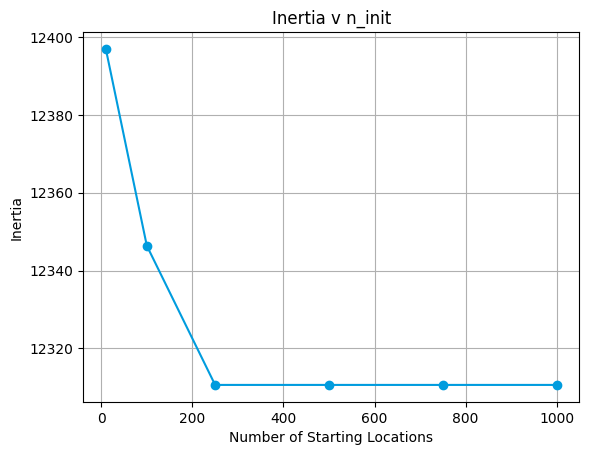

In [40]:
tuned_init = []
js = [10, 100, 250, 500, 750, 1000]
for j in js:
    kmc_tuned = KMeans(
        n_clusters = 16
        , init = 'k-means++'
        , n_init = j
        , max_iter = 1000
        , random_state = 202504
    ).fit(X_10)

    tuned_init.append(kmc_tuned.inertia_)

# plot the inertia results
plt.plot(
    js
    , tuned_init
    , marker='o'
    , color = '#009CDE'   # NCAA blue
)
plt.xlabel('Number of Starting Locations')
plt.ylabel('Inertia')
plt.title('Inertia v n_init')
plt.grid(True)

It's pretty clear from looking at the plot above that using `n_init` = 250 will be the best case for us; somewhere in that range from 1-750 the optimal starting arrangement was used. Ultimately though, the inertia really doesn't decrease very much, so we will try an alternative algorithm.

In [28]:
# kmc final
kmc_final = KMeans(
    n_clusters = 16
    , init = 'k-means++'
    , n_init = 250
    , max_iter = 1000
    , random_state = 202504
).fit(X_10)


In [29]:
# assign labels to the data frame from the final KMeans algorithm
seeds_pred = kmc_final.labels_ + 1   # add 1 to get seeds 1 - 16

# drop cluster column from pca plot
df = df.drop(columns = ['Cluster'])

# assign predicted seeds to 
df['seeds_pred'] = seeds_pred

### Agglomerative / Hierarchical Clustering
Another approach we can use is agglomerative clustering. What attracted me to this approach is the ability to split the trees at different levels resulting in different cluster counts. I will start with a cosine similarity measure and complete linkage. The cosine similarity measures the distance between vectors and complete linkage links the sub-groups with the maximum distance between sets.  

If this doesn't perform well we can tune our hyperparameters like distance and linkage.

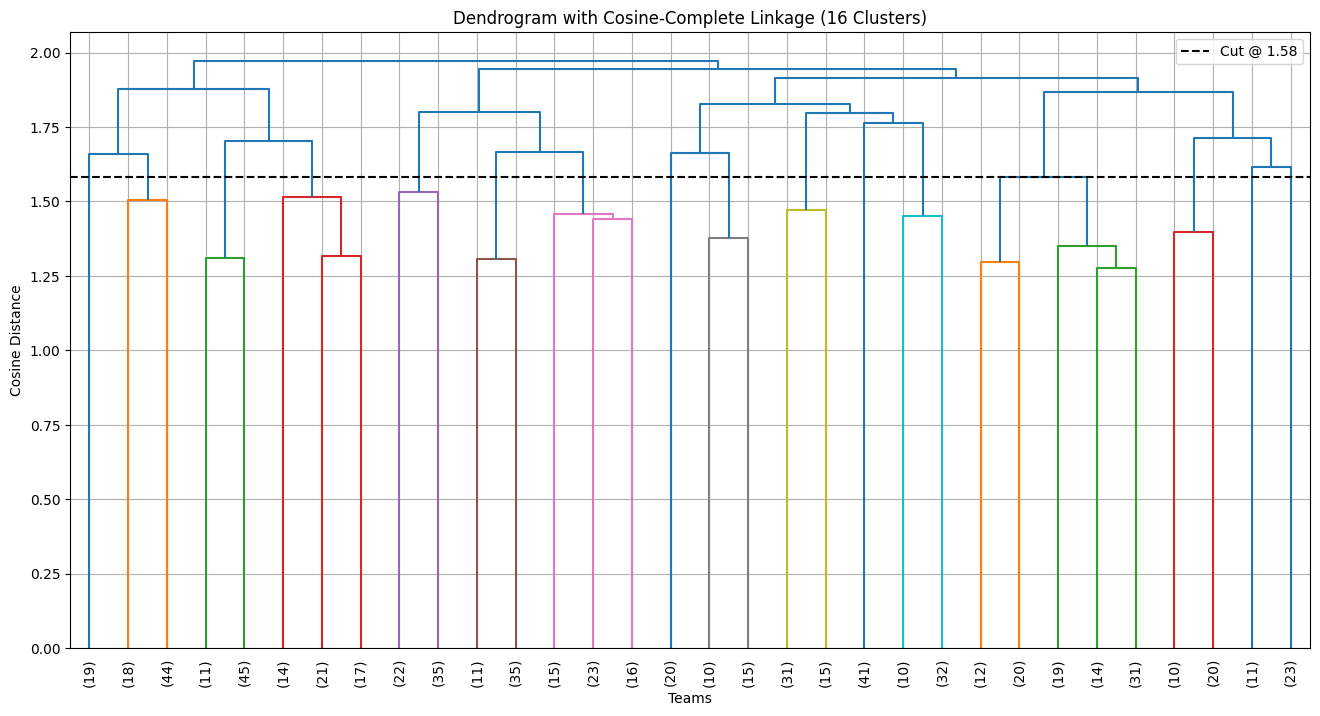

In [30]:
# agglo and dendogram
# used lots of chat gpt to get this code

# compute the linkage matrix
Z = linkage(X_10, method='complete', metric='cosine')

# calculate where we need to make the cut point
N = X_10.shape[0]
K = 16
dists_sorted = np.sort(Z[:,2])[::-1]
cut_distance = dists_sorted[K-1]

# plot the dendogram with different colors
plt.figure(figsize=(16,8))
dendrogram(
    Z,
    truncate_mode='lastp',
    p=32,
    color_threshold=cut_distance,
    leaf_rotation=90.,
    leaf_font_size=10.
)
plt.axhline(y=cut_distance, c='k', linestyle='--', label=f'Cut @ {cut_distance:.2f}')
plt.title(f'Dendrogram with Cosine-Complete Linkage (16 Clusters)')
plt.xlabel('Teams')
plt.ylabel('Cosine Distance')
plt.legend()
plt.grid(True)
plt.show()

dendro_clusters_cosine = fcluster(
    Z
    , t = cut_distance
    , criterion = 'distance'
)

# save to our df for comparison
df['seeds_agglo_cosine'] = dendro_clusters_cosine


I plotted the dendogram above with lots of help from ChatGPT. One thing concerns me about the dendogram, and that's the number of teams in each cluster. I tried to visualize the top cuts of the dendogram to show how many teams would fall into each group. We would expect 42 or 43 teams in each group (680/16 = 42.5); however, what we see is some groups having > 60 teams and others having 32 or fewer.  

To try and resolve this, I will fit a new model and dendogram using the 'ward' linkage. That linkage proved to be the most effective in our earlier assignment. The ward linkage will minimize the total variance within clusters using a Euclidean distance measure.

New Ward cut distance: 21.5611


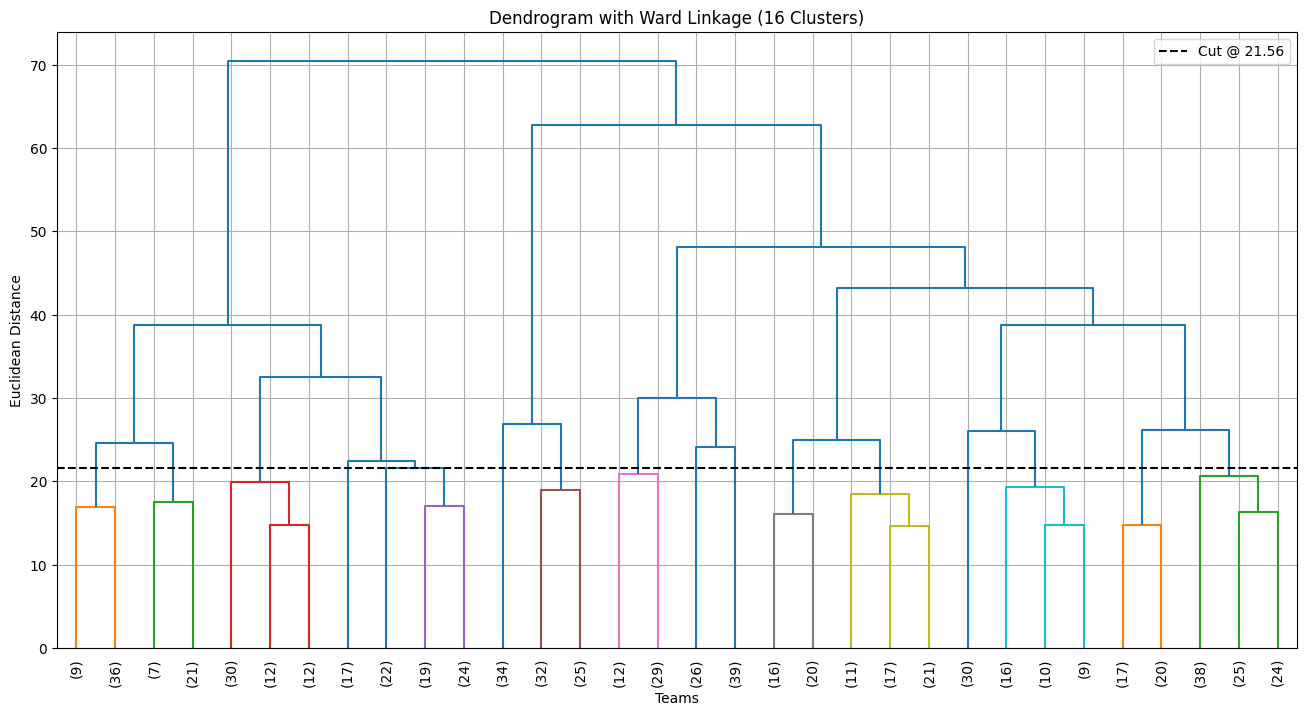

In [31]:
# dendo with ward linkage
Z_ward = linkage(X_10, method='ward')
# Number of points
N = X_10.shape[0]
K = 16

# Distances
dists_sorted = np.sort(Z_ward[:,2])[::-1]
cut_distance = dists_sorted[K-1]
print(f"New Ward cut distance: {cut_distance:.4f}")

plt.figure(figsize=(16,8))
dendrogram(
    Z_ward,
    truncate_mode='lastp',
    p=32,
    color_threshold=cut_distance,
    leaf_rotation=90.,
    leaf_font_size=10.
)
plt.axhline(y=cut_distance, c='k', linestyle='--', label=f'Cut @ {cut_distance:.2f}')
plt.title(f'Dendrogram with Ward Linkage (16 Clusters)')
plt.xlabel('Teams')
plt.ylabel('Euclidean Distance')
plt.legend()
plt.grid(True)
plt.show()

# save the results for comparisons with other methods
dendro_clusters_ward = fcluster(
    Z_ward
    , t = cut_distance
    , criterion = 'distance'
)

# save to our df for comparison
df['seeds_agglo_ward'] = dendro_clusters_ward


I will keep both results from cosine-full and ward methods to compute confusion matrices based on our results and compare those to the KMeans method.  

## Evaluation
Let's compare how our clustering compares to the actual seeds that teams were given. I will create a new data frame with the Season, TeamID, the clustering seeds, and the actual seeds.

In [32]:
# extract the columns we want
df_compare = df[['Season', 'TeamID', 'seeds_pred', 'seeds_agglo_cosine', 'seeds_agglo_ward']].copy()

# join to the data frame with the actual seeds
df_compare = df_compare.merge(
    MNCAATourneySeeds
    , how = 'left'
    , on = ['Season', 'TeamID']
)

# turn Seed into an int column
df_compare['Seed'] = df_compare['Seed'].astype(int)

# rename the columns for clarity
df_compare.columns = ['Season', 'TeamID', 'seeds_kmeans', 'seeds_agglo_cosine', 'seeds_agglo_ward', 'seeds_actual']



### Predicted Seed Values
One important consideration for evaluation needs to be that we didn't try and predict the actual seeds, just what teams should be seeded together. To make this less confusing I will map the predicted seeds to letters. A_kmeas - P_kmeans, A_cosine - P_cosine, and A_ward - P_ward. Finally, I will add back in the actual team names. 

In [33]:
# letters and numbers
cluster_letters = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P']
numbers = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]

# dictionary for mapping
letter_map = dict(
    zip(numbers, cluster_letters)
)

# replace values in df_compare
df_compare['seeds_kmeans'] = df_compare['seeds_kmeans'].replace(letter_map)
df_compare['seeds_kmeans'] = df_compare['seeds_kmeans'] + '_kmeans'

df_compare['seeds_agglo_cosine'] = df_compare['seeds_agglo_cosine'].replace(letter_map)
df_compare['seeds_agglo_cosine'] = df_compare['seeds_agglo_cosine'] + '_cosine'

df_compare['seeds_agglo_ward'] = df_compare['seeds_agglo_ward'].replace(letter_map)
df_compare['seeds_agglo_ward'] = df_compare['seeds_agglo_ward'] + '_ward'

# add in the team names
df_compare = df_compare.merge(
    MTeams[['TeamID', 'TeamName']]
    , how = 'inner'
    , on = 'TeamID'
)

### Evaluating Seeding Clusters
To evaluate the new proposed seeds, I printed lists of the new seeds grouped together along with their acutual seeds in the tournament. I want to see what teams the algorithms think should be grouped together. I looked at only the most recent tournament year.

### For KMEANS

In [34]:
temp = df_compare[df_compare['Season'] == 2025]
temp[['Season', 'TeamName', 'seeds_kmeans', 'seeds_actual']].sort_values(by = ['seeds_kmeans', 'seeds_actual']).head(34)

,Season,TeamName,seeds_kmeans,seeds_actual
614,2025,Wisconsin,A_kmeans,3
650,2025,Michigan,A_kmeans,5
617,2025,BYU,A_kmeans,6
670,2025,Kansas,A_kmeans,7
653,2025,Louisville,A_kmeans,8
654,2025,Creighton,A_kmeans,9
660,2025,Lipscomb,A_kmeans,14
628,2025,Mt St Mary's,A_kmeans,16
663,2025,St Francis PA,A_kmeans,16
647,2025,Michigan St,D_kmeans,2


In [35]:
temp[['Season', 'TeamName', 'seeds_kmeans', 'seeds_actual']].sort_values(by = ['seeds_kmeans', 'seeds_actual']).tail(34)

,Season,TeamName,seeds_kmeans,seeds_actual
624,2025,Akron,J_kmeans,13
661,2025,Bryant,J_kmeans,15
632,2025,Purdue,K_kmeans,4
616,2025,Oregon,K_kmeans,5
639,2025,Texas,K_kmeans,11
640,2025,Xavier,K_kmeans,11
675,2025,Colorado St,K_kmeans,12
642,2025,High Point,K_kmeans,13
625,2025,Montana,K_kmeans,14
677,2025,UNC Wilmington,K_kmeans,14


### For Cosine Hierarchical

In [36]:
temp = df_compare[df_compare['Season'] == 2025]
temp[['Season', 'TeamName', 'seeds_agglo_cosine', 'seeds_actual']].sort_values(by = ['seeds_agglo_cosine', 'seeds_actual']).head(34)

,Season,TeamName,seeds_agglo_cosine,seeds_actual
647,2025,Michigan St,A_cosine,2
625,2025,Montana,A_cosine,14
626,2025,Robert Morris,A_cosine,15
614,2025,Wisconsin,B_cosine,3
654,2025,Creighton,B_cosine,9
639,2025,Texas,B_cosine,11
623,2025,Liberty,B_cosine,12
675,2025,Colorado St,B_cosine,12
660,2025,Lipscomb,B_cosine,14
633,2025,Clemson,C_cosine,5


In [37]:
temp[['Season', 'TeamName', 'seeds_agglo_cosine', 'seeds_actual']].sort_values(by = ['seeds_agglo_cosine', 'seeds_actual']).tail(34)

,Season,TeamName,seeds_agglo_cosine,seeds_actual
624,2025,Akron,F_cosine,13
631,2025,Kentucky,G_cosine,3
615,2025,Arizona,G_cosine,4
650,2025,Michigan,G_cosine,5
670,2025,Kansas,G_cosine,7
673,2025,Arkansas,G_cosine,10
656,2025,North Carolina,G_cosine,11
659,2025,Yale,G_cosine,13
677,2025,UNC Wilmington,G_cosine,14
628,2025,Mt St Mary's,G_cosine,16


### For Ward Hierarchical

In [38]:
temp = df_compare[df_compare['Season'] == 2025]
temp[['Season', 'TeamName', 'seeds_agglo_ward', 'seeds_actual']].sort_values(by = ['seeds_agglo_ward', 'seeds_actual']).head(34)

,Season,TeamName,seeds_agglo_ward,seeds_actual
665,2025,St John's,A_ward,2
615,2025,Arizona,A_ward,4
650,2025,Michigan,A_ward,5
668,2025,Memphis,A_ward,5
670,2025,Kansas,A_ward,7
655,2025,New Mexico,A_ward,10
661,2025,Bryant,A_ward,15
664,2025,Florida,B_ward,1
613,2025,Alabama,B_ward,2
634,2025,Illinois,B_ward,6


In [39]:
temp[['Season', 'TeamName', 'seeds_agglo_ward', 'seeds_actual']].sort_values(by = ['seeds_agglo_ward', 'seeds_actual']).tail(34)

,Season,TeamName,seeds_agglo_ward,seeds_actual
658,2025,UC San Diego,G_ward,12
675,2025,Colorado St,G_ward,12
625,2025,Montana,G_ward,14
660,2025,Lipscomb,G_ward,14
644,2025,Wofford,G_ward,15
627,2025,American Univ,G_ward,16
648,2025,Iowa St,I_ward,3
649,2025,Texas A&M,I_ward,4
669,2025,Missouri,I_ward,6
637,2025,Georgia,I_ward,9


## Discussions and Further Work
Overall I think we obtained decent and decipherable results. But there's definitely room for improvements. After reviewing the results I think the agglomerative / hierarchical clustering methods work better; the cosine-complete linkage method in particular. 

### KMEANS vs HIERARCHICAL
The kmeans algorithm looks for and updates centroids in the data points and assigns labels based on the closest points to those centroids. When the closest points get updated, the centroids also get updated. This requires an additional abstract parameter to build our clusters. The agglomerative / hierarchical methods use more of the inherent 'location' of the data points in the feature space. No centroids get moved and calculated, only the distance between the static points gets calculated. The reason I think the cosine measure, complete linkage version works better than the ward measure, is that the ward measure also relies on a type of centroid to make branching decisions. Ultimately in our case here it seems more reliable to trust the inherent structure of our PCA decomposition. 

### Further Work
I think including opponent specific statistics for each team in the tournament would achieve better results on this specific problem. My version takes into account a teams opponent statistics in aggregate, but I think something could be said for measuring how top teams compete against one another.  

Another future project in this space could also use some different clustering algorithms. DBScan could be used to explore the clusters in this problem. However, one concern I do have about that approach is the ability for DBScan to group items in irregular clusters, this could lead to some odd groupings.

## Conclusion
I leave this project feeling encouraged that an improved version of this approach can yield meaningful results. A lot of work still needs to be done, but because the source data is so rich, I feel like it would only take time and some creative ideas to remove the subjectivity entirely from this process. 

Ultimately, the results didn't definitively show what I hoped they might, but the clustering did a decent enough job that some interesting results emerged. For example, the algorithms liked grouping Alabama State, a small HBCU, with traditional powerhouse programs from bigger conferences like the SEC and Big East. On the flip side of that, the big program schools from the power conferences of the Big XII and SEC, Iowa St, Missouri, and Texas A&M, all were grouped with mid majors and small schools who entered via winning their conference tournaments. This means one of two things, that the selection committee gives too much credit to big schools and conferences, or too little credit to the smaller schools.  

Thanks for taking the time to review my project. I enjoyed working on it and took a lot away from the experience. One thing I would do differently next time is have a clearer picture of how to validate an unsupervised machine learning project. I had the goal of grouping teams subjectively, but when it came time to actually judge those groupings, I needed to do some more work to make it all make sense. 


## References
Jeff Sonas, Paul Mooney, Addison Howard, and Will Cukierski. March Machine Learning Mania 2025. https://kaggle.com/competitions/march-machine-learning-mania-2025, 2025. Kaggle.
